# **Régression Ridge**

*Fonctionne avec Python 3.10.9 (Anaconda 23.3.1)*

## **Importation des bibliothèques**

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pour les traîtements sur les variables
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Modèles de ML utilisés
from sklearn.linear_model import Ridge
from sklearn import kernel_ridge

# Pour gridsearch
from sklearn import model_selection

# Pour mesures des metrics des résultats
from sklearn import metrics

# Pour mise en forme des résultats
import colorama

## **Importation du dataset**

In [16]:
dataset_a_utiliser = "data_clean.xlsx"

data = pd.read_excel(dataset_a_utiliser)

## **Fonctions**

In [17]:
def split_and_scale(dataset_name, y_column, features_list, numeric_features, categorical_features, stratification):

    ##############################
    # Split du dataset en X et y #
    ##############################

    global X
    global y

    X = data.loc[:,features_list] # On ajoute nos features dans le X
    y = data.loc[:,y_column] # On ajoute ce qu'on veut prédire dans le y

    ############################
    # Scaling et Encoding de X #
    ############################

    global feature_encoder

    numeric_transformer = StandardScaler()

    categorical_transformer = OneHotEncoder()

    feature_encoder = ColumnTransformer(
                transformers=[
                    ('cat', categorical_transformer, categorical_features),    
                    ('num', numeric_transformer, numeric_features)
                    ]
                )
    X = feature_encoder.fit_transform(X)


    ####################################
    # Split de X et y en train et test #
    ####################################

    global X_train
    global X_test
    global y_train
    global y_test

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=0,
                                                        stratify=eval(stratification))

## **Features**

In [18]:
######################
# Choix des features #
######################

dataset_name = data

# Si rien mettre []
categorical_features = [
                        'BuildingType',
                        'PrimaryPropertyType',
                        'Neighborhood',
                        'ZipCode',
                        'YearBuilt'
                       ]

# Si rien mettre []
numeric_features = [
                    'NumberofBuildings',
                    'NumberofFloors',
                    'PropertyGFAParking',
                    'PropertyGFABuilding(s)',
                    'Latitude',
                    'Longitude',
                    'age_bat'
                   ]

# Toutes les features
features_list = categorical_features + numeric_features

## ***Ridge***

In [19]:
# Targets à estimer
targets = ['SiteEnergyUse_kBtu', 'TotalGHGEmissions']

# "y" pour stratifier y, sinon "None"
stratification = "None"

# Afficher les résultats détaillés (True/False)
details = False

for i in targets:

    y_column=i

    print(f"=========== [{i}] ===========")


    # Split & Scale du dataset
    split_and_scale(dataset_name, y_column, features_list, numeric_features, categorical_features, stratification)


    # Entraînement simple
    modele = Ridge() # Paramètres par défaut
    modele.fit(X_train, y_train) # Étape d'entraînement
    print("--- Entraînement simple : ---")
    print(f"Scores du modèle pour prédire {i} :")
    y_pred = modele.predict(X_test)
    print(f"R² : {modele.score(X_train, y_train):.3f} (train) et {colorama.Style.BRIGHT}{colorama.Back.CYAN}{colorama.Fore.BLACK} {modele.score(X_test, y_test):.3f} {colorama.Style.RESET_ALL} (test)")
    print(f"MSE : {metrics.mean_squared_error(y_test, y_pred):.4}")
    print(f"MAE : {metrics.mean_absolute_error(y_test, y_pred):.4}")


    ###############################################
    # Paramétrage de GridSearchCV et entraînement #
    ###############################################

    print("--- GridSearch : ---")

    alphas = np.linspace(17, 18, 100)
    # après essais, les meilleurs résultats sont obtenus quand le laisse alpha à 1 (valeur par défaut)

    # Fixer les valeurs des hyperparamètres à tester
    param_grid = [
        {'solver':['lsqr', 'sparse_cg', 'sag']},
        {'solver':['saga', 'cholesky'], 'fit_intercept':[False], 'max_iter':[2000]}, # saga et cholesky ne fonctionnent qu'avec fit_intercept=False ; j'augmente max iter sinon ça ne converge pas
        {'solver':['lbfgs'], 'positive':[True]} # lbfgs ne fonctionne qu'avec positive=True
                 ]
    # Déterminer le score qu'on veut optimiser
    score = 'r2'

    # Je le sors ici car je vais réutiliser cette valeur plus tard
    cv = 5

    grid = model_selection.GridSearchCV(
        Ridge(), # On indique le modèle à tester
        param_grid,     # hyperparamètres à tester
        cv=cv,           # nombre de folds de validation croisée
        scoring=score   # score à optimiser
    )

    # Optimiser ce modèle sur le jeu d'entraînement
    grid.fit(X_train, y_train)


    ###########################
    # Affichage des résultats #
    ###########################

    # Afficher le(s) hyperparamètre(s) optimaux
    print(f"Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement ({i}): {grid.best_params_}")

    # Afficher les performances correspondantes
    if details == True:
        print('Résultats pour chaque fold :')
        for j in range(cv):
            print(f"Fold n°{j+1} :", eval(f"grid.cv_results_['split{j}_test_score']"), f"(Pour les paramètres : {grid.cv_results_['params']})")

        print("\nRésultats de la validation croisée :")
        for mean, std, params in zip(
                grid.cv_results_['mean_test_score'], # score moyen
                grid.cv_results_['std_test_score'],  # écart-type du score
                grid.cv_results_['params']           # valeur de l'hyperparamètre
            ):

            print(f"{score} (moyen) : {mean:.04f} (+/-{std*2:.04f}) pour {params}")


    ###################################################################
    # Prédiction sur le jeu de test avec les hyperparamètres optimaux #
    ###################################################################

    # GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement.
    y_pred = grid.predict(X_test)
    print(f"Score sur le jeu de test ({i}, avec paramètres optimaux) :")
    print(f"R² : {colorama.Style.BRIGHT}{colorama.Back.GREEN}{colorama.Fore.BLACK} {metrics.r2_score(y_test, y_pred):.3f} {colorama.Style.RESET_ALL}")
    print(f"MSE : {metrics.mean_squared_error(y_test, y_pred):.4}")
    print(f"MAE : {metrics.mean_absolute_error(y_test, y_pred):.4}")

    print('_'*80, "\n")

    

=========== [SiteEnergyUse_kBtu] ===========
--- Entraînement simple : ---
Scores du modèle pour prédire SiteEnergyUse_kBtu :
R² : 0.728 (train) et  0.584  (test)
MSE : 7.557e+13
MAE : 4.364e+06
--- GridSearch : ---
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (SiteEnergyUse_kBtu): {'positive': True, 'solver': 'lbfgs'}
Score sur le jeu de test (SiteEnergyUse_kBtu, avec paramètres optimaux) :
R² :  0.588 
MSE : 7.48e+13
MAE : 4.127e+06
________________________________________________________________________________ 

=========== [TotalGHGEmissions] ===========
--- Entraînement simple : ---
Scores du modèle pour prédire TotalGHGEmissions :
R² : 0.594 (train) et  0.318  (test)
MSE : 6.501e+04
MAE : 137.6
--- GridSearch : ---
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (TotalGHGEmissions): {'positive': True, 'solver': 'lbfgs'}
Score sur le jeu de test (TotalGHGEmissions, avec paramètres optimaux) :
R² :  0.319 
MSE : 6.487e+04
MAE : 130.8
____________________________

## **Importance des features**

,Features,coefficients
0,Campus,209.540179
1,NonResidential,-68.540168
2,Nonresidential COS,-86.880080
3,SPS-District K-12,-54.119932
4,Distribution Center,-183.974385
...,...,...
200,PropertyGFAParking,-15.601746
201,PropertyGFABuilding(s),188.398604
202,Latitude,-46.258858
203,Longitude,17.600149


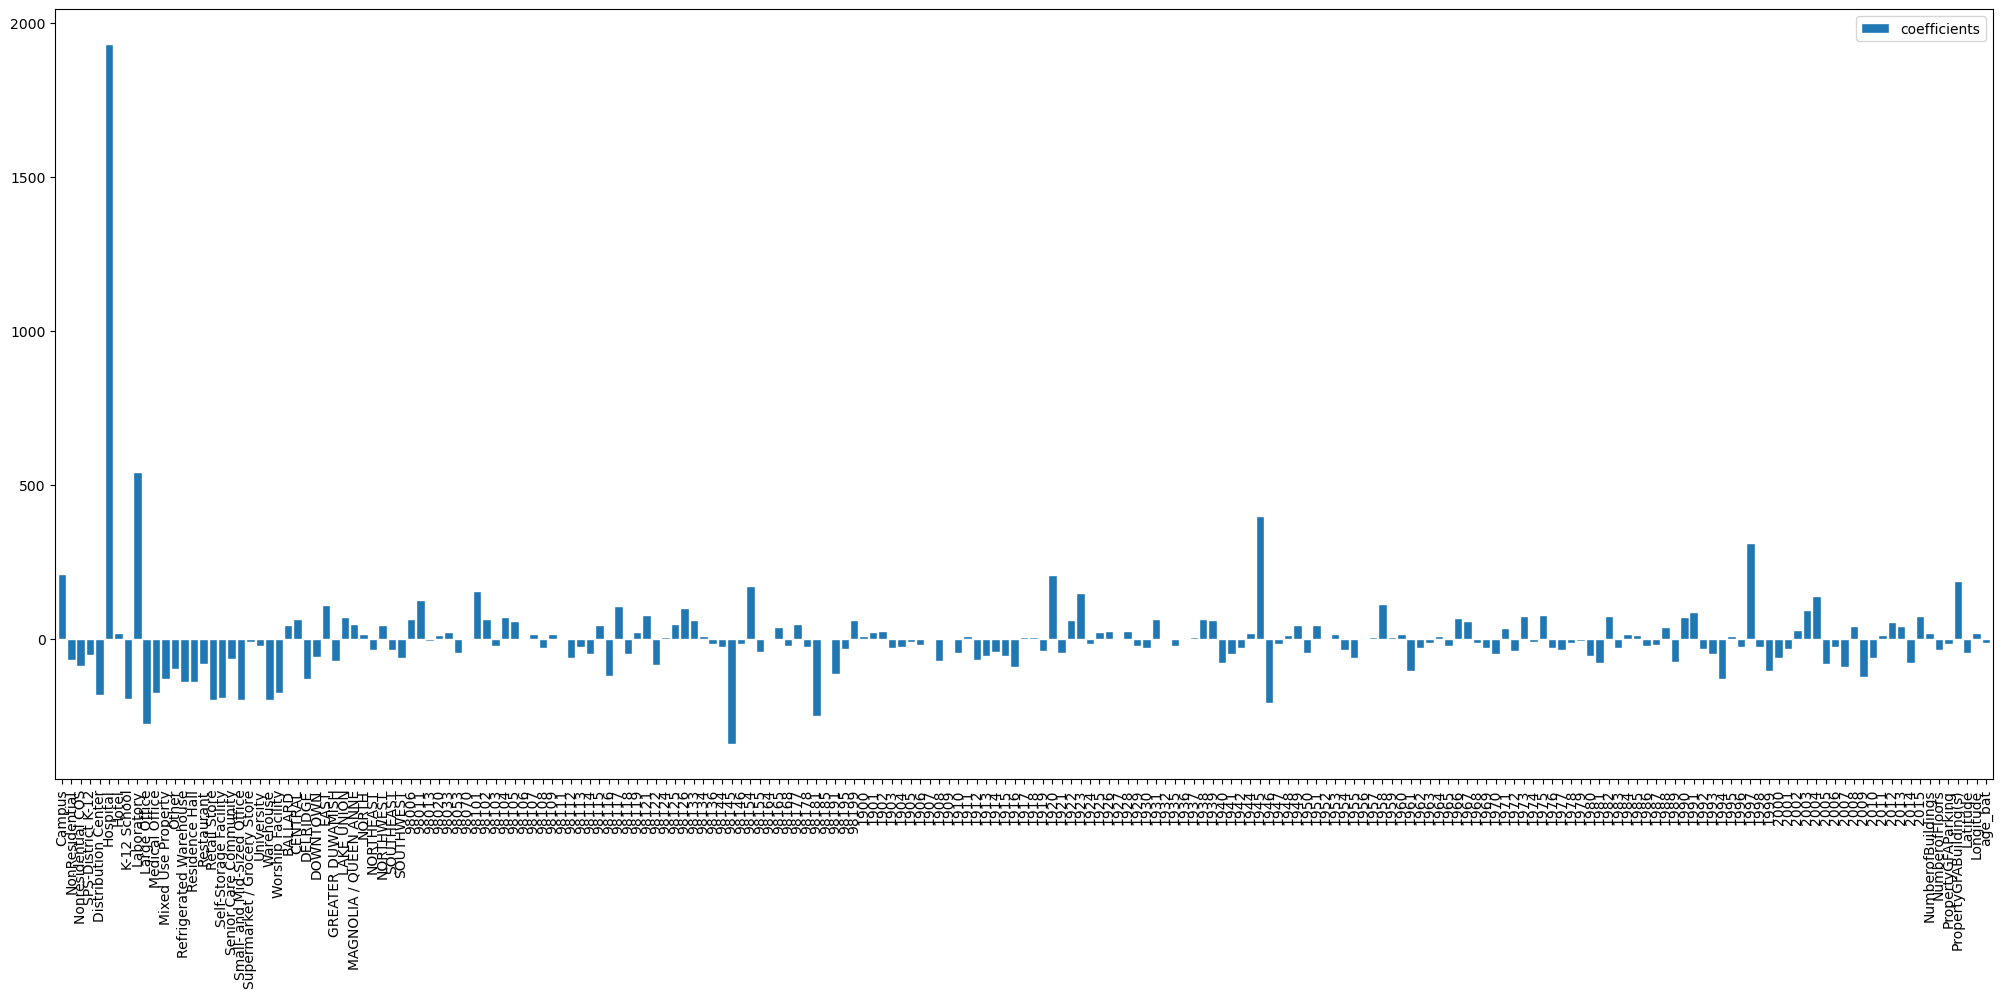

In [20]:
# Si on n'a pas utilisé de features catégorielles, alors on va mettre categories_names_concat à []
if categorical_features == []:
    categories_names_concat = []
# Sinon, on fait la procédure habituelle
else:
    categories_names = feature_encoder.transformers_[0][1].categories_
    # "feature_encoder.transformers_" est une liste de tuples, un tuple par transformer.
    # On obtient le transformer de catégorie qui est OneHotEncoder() avec [0][1] (2 ème élément du premier tuple de la liste).
    # On ajoute ".categories_" pour voir les catégories traitées par ce transformer.
    
    categories_names_concat = [item for array in categories_names for item in array]

numerical_column_names = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'Latitude', 'Longitude', 'age_bat']



# On regroupe ici toutes les catégories et le nom des colonnes numériques
# np.append() va retourner un array avec une liste dedans

all_features_names = np.append(categories_names_concat, numerical_column_names)


# On créé le dataframe feature_importance avec en première colonne tous les éléments de all_features_names,
# et en deuxième colonne les coefficients obtenus avec le machine learning.
# Ce dataframe nous servira pour la représentation graphique de nos résultats



# On adapte la synthaxe en fonction du modèle utilisé.
if type(modele) == type(Ridge()):
    coef_modele = modele.coef_
else:
    coef_modele = modele.feature_importances_


feature_importance = pd.DataFrame({
    "Features": all_features_names,
    "coefficients": coef_modele
})

# Les coefficients peuvent être positifs ou négatifs, ce qui nous intéresse pour le moment est leur valeur absolue.
#feature_importance["coefficients"] = feature_importance["coefficients"].abs()

display(feature_importance)
feature_importance.plot(x='Features', y='coefficients', kind="bar", width=0.9, linewidth=1, edgecolor = "white", figsize = (25, 10)).set(xlabel=None);

## ***KernelRidge***

In [21]:
# Targets à estimer
targets = ['SiteEnergyUse_kBtu', 'TotalGHGEmissions']

# "y" pour stratifier y, sinon "None"
stratification = "None"

# Afficher les résultats détaillés (True/False)
details = False

for i in targets:

    y_column=i

    print(f"=========== [{i}] ===========")


    # Split & Scale du dataset
    split_and_scale(dataset_name, y_column, features_list, numeric_features, categorical_features, stratification)


    # Entraînement simple
    modele = kernel_ridge.KernelRidge() # Paramètres par défaut
    #alpha=1.0, # valeur par défaut 
    #kernel='rbf', # noyau Gaussien
    #gamma=0.01)   # valeur de 1/(2 * sigma**2)
    
    
    
    
    modele.fit(X_train, y_train) # Étape d'entraînement
    print("--- Entraînement simple : ---")
    print(f"Scores du modèle pour prédire {i} :")
    y_pred = modele.predict(X_test)
    print(f"R² : {modele.score(X_train, y_train):.3f} (train) et {colorama.Style.BRIGHT}{colorama.Back.CYAN}{colorama.Fore.BLACK} {modele.score(X_test, y_test):.3f} {colorama.Style.RESET_ALL} (test)")
    print(f"MSE : {metrics.mean_squared_error(y_test, y_pred):.4}")
    print(f"MAE : {metrics.mean_absolute_error(y_test, y_pred):.4}")


    ###############################################
    # Paramétrage de GridSearchCV et entraînement #
    ###############################################

    print("--- GridSearch : ---")

    # Fixer les valeurs des hyperparamètres à tester
    param_grid = [
                  {'kernel':['linear', 'poly', 'cosine', 'sigmoid'], 'alpha':[1]},
                  {'gamma':[0.01, 0.1, 0.2], 'kernel':['rbf', 'laplacian', 'polynomial'], 'alpha':[0.01, 0.1, 1]}
                 ]
    # Déterminer le score qu'on veut optimiser
    score = 'r2'

    # Je le sors ici car je vais réutiliser cette valeur plus tard
    cv = 5

    grid = model_selection.GridSearchCV(
        kernel_ridge.KernelRidge(), # On indique le modèle à tester
        param_grid,     # hyperparamètres à tester
        cv=cv,           # nombre de folds de validation croisée
        scoring=score   # score à optimiser
    )

    # Optimiser ce modèle sur le jeu d'entraînement
    grid.fit(X_train, y_train)


    ###########################
    # Affichage des résultats #
    ###########################

    # Afficher le(s) hyperparamètre(s) optimaux
    print(f"Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement ({i}): {grid.best_params_}")

    # Afficher les performances correspondantes
    if details == True:
        print('Résultats pour chaque fold :')
        for j in range(cv):
            print(f"Fold n°{j+1} :", eval(f"grid.cv_results_['split{j}_test_score']"), f"(Pour les paramètres : {grid.cv_results_['params']})")

        print("\nRésultats de la validation croisée :")
        for mean, std, params in zip(
                grid.cv_results_['mean_test_score'], # score moyen
                grid.cv_results_['std_test_score'],  # écart-type du score
                grid.cv_results_['params']           # valeur de l'hyperparamètre
            ):

            print(f"{score} (moyen) : {mean:.04f} (+/-{std*2:.04f}) pour {params}")


    ###################################################################
    # Prédiction sur le jeu de test avec les hyperparamètres optimaux #
    ###################################################################

    # GridSearchCV a automatiquement ré-entraîné le meilleur modèle sur l’intégralité du jeu d’entraînement.
    y_pred = grid.predict(X_test)
    print(f"Score sur le jeu de test ({i}, avec paramètres optimaux) :")
    print(f"R² : {colorama.Style.BRIGHT}{colorama.Back.GREEN}{colorama.Fore.BLACK} {metrics.r2_score(y_test, y_pred):.3f} {colorama.Style.RESET_ALL}")
    print(f"MSE : {metrics.mean_squared_error(y_test, y_pred):.4}")
    print(f"MAE : {metrics.mean_absolute_error(y_test, y_pred):.4}")

    print('_'*80, "\n")

    

=========== [SiteEnergyUse_kBtu] ===========
--- Entraînement simple : ---
Scores du modèle pour prédire SiteEnergyUse_kBtu :
R² : 0.728 (train) et  0.582  (test)
MSE : 7.594e+13
MAE : 4.352e+06
--- GridSearch : ---
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (SiteEnergyUse_kBtu): {'alpha': 0.1, 'gamma': 0.01, 'kernel': 'laplacian'}
Score sur le jeu de test (SiteEnergyUse_kBtu, avec paramètres optimaux) :
R² :  0.635 
MSE : 6.632e+13
MAE : 4.059e+06
________________________________________________________________________________ 

=========== [TotalGHGEmissions] ===========
--- Entraînement simple : ---
Scores du modèle pour prédire TotalGHGEmissions :
R² : 0.594 (train) et  0.318  (test)
MSE : 6.503e+04
MAE : 137.7
--- GridSearch : ---
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (TotalGHGEmissions): {'alpha': 0.1, 'gamma': 0.01, 'kernel': 'laplacian'}
Score sur le jeu de test (TotalGHGEmissions, avec paramètres optimaux) :
R² :  0.448 
MSE : 5.258e+04
MAE : 124